## OPC PDG

# Integrantes: Sandra Niño y Johnatan Garzón

En el presente jupyter notebook se hará uso de LDA (Latent Dirichlet Allocation) para que las respuestas a la pregunta "Para ti,¿Que sí es paz?", en este caso entendidos como documentos, formen topics o categorías de palabras relacionadas  a la pregunta.

In [1]:
%matplotlib inline
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import datasets, metrics
from sklearn import preprocessing
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#remove stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/garzuzo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/garzuzo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Lectura de datos procesados

Creamos el dataframe a partir de los datos procesados anteriormente

In [2]:
df=pd.read_excel('./data/df_limpieza.xlsx')

In [3]:
df.head()

,Narrativa_lemmatized
0,tranquilidad convivencia casa educacion colect...
1,semana semana padres cuidadores pasar hijos es...
2,tranquilidad familia empleabilidad tolerancia ...
3,accion dano integracion comunitaria respeto de...
4,procesos formativo multiplicacion numero alian...


## LDA (Latent Dirichlet Allocation)

Se crea matriz Documento-Palabra como input para LDA.

Se hará uso de CountVectorizer. Este se configurará para que tenga en cuenta palabras que aparezcan como mínimo 10 veces y que solo contengan letras, que su longitud sea de mínimo 3 caracteres y no borre los bigramas(palabras que tienen un guión bajo).

In [4]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimo numero de ocurrencias
                             token_pattern='[a-z\_A-Z]{3,}',  # num chars > 3, que contenga bigramas (palabra_palabra)
                            )

data_vectorized = vectorizer.fit_transform(df['Narrativa_lemmatized'])

Este es un ejemplo de lo que retorna data_vectorized. Esta es una matriz de dispersión que tiene en cuenta las ocurrencias de la palabra en cada documento. 
Por ejemplo, en el primer documento vemos que hay 2 palabras con 2 ocurrencias que son: tranquilidad y educación. 

In [5]:
df.Narrativa_lemmatized[0]

'tranquilidad convivencia casa educacion colectividad respeto tranquilidad acceso educacion humanizacion espacio siempre camino'

In [6]:
print(data_vectorized[0:10])

  (0, 393)	1
  (0, 168)	1
  (0, 2)	1
  (0, 360)	1
  (0, 150)	2
  (0, 67)	1
  (0, 100)	1
  (0, 426)	2
  (1, 183)	1
  (1, 165)	1
  (1, 214)	2
  (1, 437)	2
  (1, 181)	1
  (1, 259)	1
  (1, 213)	2
  (1, 309)	2
  (1, 301)	2
  (1, 168)	1
  (2, 371)	1
  (2, 16)	1
  (2, 449)	1
  (2, 127)	1
  (2, 416)	1
  (2, 214)	1
  (2, 181)	1
  :	:
  (6, 40)	1
  (6, 422)	1
  (6, 83)	1
  (6, 289)	2
  (6, 416)	2
  (7, 362)	1
  (7, 214)	1
  (7, 426)	1
  (8, 140)	1
  (8, 348)	1
  (8, 155)	1
  (8, 26)	1
  (8, 446)	1
  (8, 307)	1
  (8, 85)	1
  (8, 400)	1
  (8, 4)	1
  (8, 77)	1
  (8, 360)	2
  (9, 137)	1
  (9, 287)	1
  (9, 438)	1
  (9, 60)	1
  (9, 289)	1
  (9, 360)	2


A continuación veremos las 20 palabras más comunes en nuestros datos. 

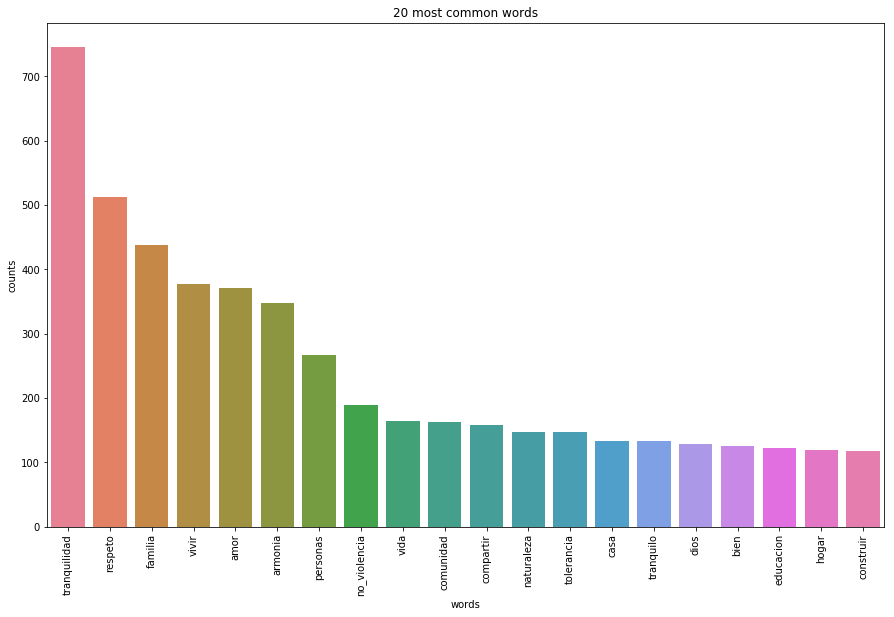

In [7]:
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Visualise the 20 most common words
plot_20_most_common_words(data_vectorized, vectorizer)

## Encontrar el mejor LDA

Realizaremos una búsqueda de parámetros para encontrar el mejor LDA. Para esto se tendrá en cuenta la variación de 2 parámetros:
- n_components, el cual es el número de topicos (grupos) que queremos formar.
- learning_decay, el cual controla la razón de aprendizaje. 

### Grid Search
Este proceso de búsqueda de parámetros consume bastante tiempo, puesto que construye múltiples modelos de LDA para todas las posibles combinaciones de dichos parámetros en el diccionario **param_grid** (cross-validated grid-search).

In [8]:
# Se definen los parámetros de búsqueda
search_params = {'n_components': [5, 6, 7 ,8], 'learning_decay': [.5, .7, .9], 'random_state':[100]}

# Se inicializa el modelo
lda = LatentDirichletAllocation()

# Se inicializa la clase GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Se realiza Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [5, 6, 7, 8], 'learning_decay': [0.5, 0.7, 0.9], 'random_state': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
print(model.best_estimator_)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=5, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=100,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)


## Escogencia del modelo

Ahora construimos el modelo con los parámetros encontrados en el paso anterior. Para esto asignamos **model.best\_estimator\_** a la variable *lda_model*

In [10]:
# Best Model
lda_model = model.best_estimator_

# Model Parameters
print("Mejores parámetros del modelo: ", model.best_params_)

# Log Likelihood Score
print("Mejor Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Perplexity del modelo: ", lda_model.perplexity(data_vectorized))

Mejores parámetros del modelo:  {'learning_decay': 0.7, 'n_components': 5, 'random_state': 100}
Mejor Log Likelihood Score:  -32922.08333896249
Perplexity del modelo:  296.85744853407823


Ahora graficamos la diferencia entre los diferentes modelos generados. Comparamos los scores de log-likelihood contra el número de tópicos, se ve claramente que el número de tópicos=5 tiene mejores resultados. También se observa que el learning_decay=0.7 tiene un mejor rendimiento que el resto.

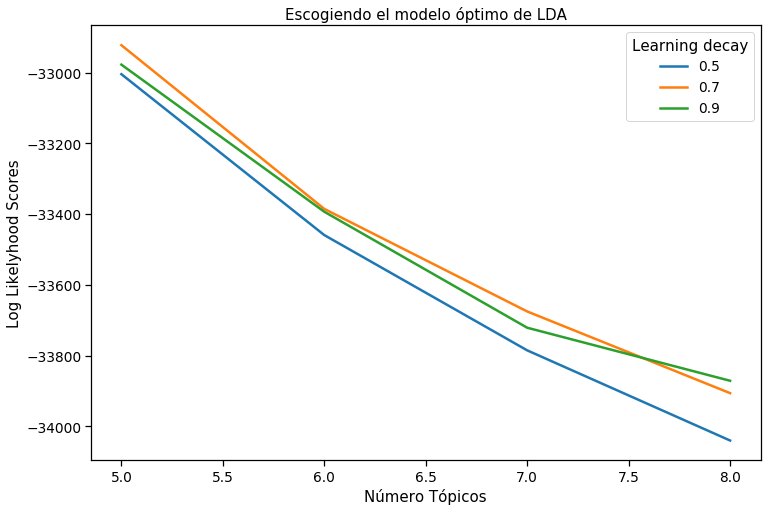

In [11]:
n_topics = [5,6,7,8]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Escogiendo el modelo óptimo de LDA")
plt.xlabel("Número Tópicos")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Tópico dominante en cada documento

Recordemos que los documentos contienen una mezcla de tópicos (grupos/categorías) y las palabras se agrupan en dichos tópicos. 
Por ende, veremos la proporción de cada tópico en cada documento y la última columna será el topico dominante, es decir, el que tiene mayor proporción. 

In [12]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_output.shape[1])]

# index names
docnames = ["Doc" + str(i) for i in range(lda_output.shape[0])]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.16,0.28,0.11,0.02,0.43,4
Doc1,0.29,0.01,0.23,0.46,0.01,3
Doc2,0.14,0.2,0.17,0.02,0.48,4
Doc3,0.26,0.16,0.02,0.19,0.37,4
Doc4,0.04,0.04,0.33,0.04,0.55,4
Doc5,0.19,0.15,0.03,0.3,0.34,4
Doc6,0.03,0.03,0.9,0.03,0.03,2
Doc7,0.05,0.3,0.05,0.55,0.05,3
Doc8,0.12,0.02,0.22,0.1,0.54,4
Doc9,0.03,0.03,0.03,0.03,0.9,4


Por ejemplo, vemos que el documento 0 tiene 44% de las palabras relacionados al topico 2, tiene 25% de las palabras relacionados al topico 4 y 8, y así sucesivamente. 

## Distribución de los tópicos en los documentos

En esta parte vemos la cantidad de documentos asociados a cada tópico. Dicha lista está ordenada de mayor a menor, por tanto el topico 9 es el que tiene asociado una mayor cantidad de documentos.

In [13]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,735
1,4,601
2,1,574
3,3,532
4,2,492


## 10 palabras de cada tópico

Hemos hablado de tópico 0,1,2,3, etc. Ahora veremos en realidad cuáles palabras están asociadas a cada tópico. Solo visualizaremos las primeras 10.  

In [14]:
# 18
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_words = 10

print_topics(lda_model,vectorizer,number_words)


Topic #0:
familia compartir casa dios bien comunidad amigos vivir disfrutar barrio

Topic #1:
tranquilidad naturaleza sentir representar problemas musica generar solidaridad animales conflicto

Topic #2:
respeto vida no_violencia personas tolerancia interior no_guerra entender existir mejor

Topic #3:
amor armonia vivir mundo respeto bueno union construir felicidad personas

Topic #4:
respeto tranquilo convivencia libertad social educacion igualdad pensar entorno vivir


Ahora con el uso de la librería pyLDAvis podremos visualizar de manera interactiva la composición de cada topico con sus respectivas palabras, así como la proporción de las mismas en el topico correspondiente. 

In [15]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne', sort_topics= False)


CPU times: user 2.88 s, sys: 89.3 ms, total: 2.97 s
Wall time: 38.8 s


In [16]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      164.461594 -195.509216       1        1  21.957947
1      -56.696827 -175.736069       2        1  13.804052
2       78.561043   92.298286       3        1  22.223937
3     -137.870270   39.860172       4        1  19.105645
4      282.307343    2.445290       5        1  22.908419, topic_info=    Category        Freq          Term       Total  loglift  logprob
426  Default  691.000000  tranquilidad  691.000000  30.0000  30.0000
181  Default  420.000000       familia  420.000000  29.0000  29.0000
26   Default  356.000000          amor  356.000000  28.0000  28.0000
35   Default  328.000000       armonia  328.000000  27.0000  27.0000
279  Default  150.000000    naturaleza  150.000000  26.0000  26.0000
..       ...         ...           ...         ...      ...      ...
97    Topic5   52.903426     construir  124.066566   0.6213  -4.2385
371   Topic5   39.941340         salud   74.835124   0.8458  -4.5195
450   Topic5   73.633030         vivir  370.751446  -0.1428  -3.9078
416   Topic5   41.260721    tolerancia  137.027497   0.2734  -4.4870
214   Topic5   31.875930         hogar  112.414984   0.2133  -4.7451

[258 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.890486      abrazo
5         3  0.960362  aceptacion
6         5  0.983898     aceptar
7         3  0.946754      actuar
10        2  0.955289   agradable
...     ...       ...         ...
450       1  0.194200       vivir
450       2  0.035064       vivir
450       3  0.113283       vivir
450       4  0.458528       vivir
450       5  0.199595       vivir

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

## Exportamos el modelo

Exportamos el modelo LDA para poder predecir futuros textos y clasificarlos en una categoria correspondiente.

In [17]:
from sklearn.externals import joblib

joblib.dump(lda_model,'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

Exportamos el modelo Vectorizer para crear nuevas matrices de dispersión acorde a los datos entrenados.

In [18]:
joblib.dump(vectorizer,'modelo_vectorizer.pkl')

['modelo_vectorizer.pkl']